LEUKEMIA CLASSIFICATION - ALL vs AML
Dataset: Golub et al. (1999) Gene Expression
Goal: Classify Acute Lymphoblastic Leukemia (ALL) vs Acute Myeloid Leukemia (AML)

[1] Loading data...
   Training data shape: (7129, 78)
   Test data shape: (7129, 70)
   Labels shape: (72, 2)

[2] Preprocessing data...
   ✓ Training samples: 38
   ✓ Test samples: 34
   ✓ Genes (features): 7129

[3] Matching labels to samples...
   Cancer types to classify: ['ALL', 'AML']
   Final training samples: 38
   Final test samples: 34

   Training distribution:
      ALL: 27 patients (71.1%)
      AML: 11 patients (28.9%)

   Test distribution:
      ALL: 20 patients (58.8%)
      AML: 14 patients (41.2%)

[4] Visualizing class distribution...


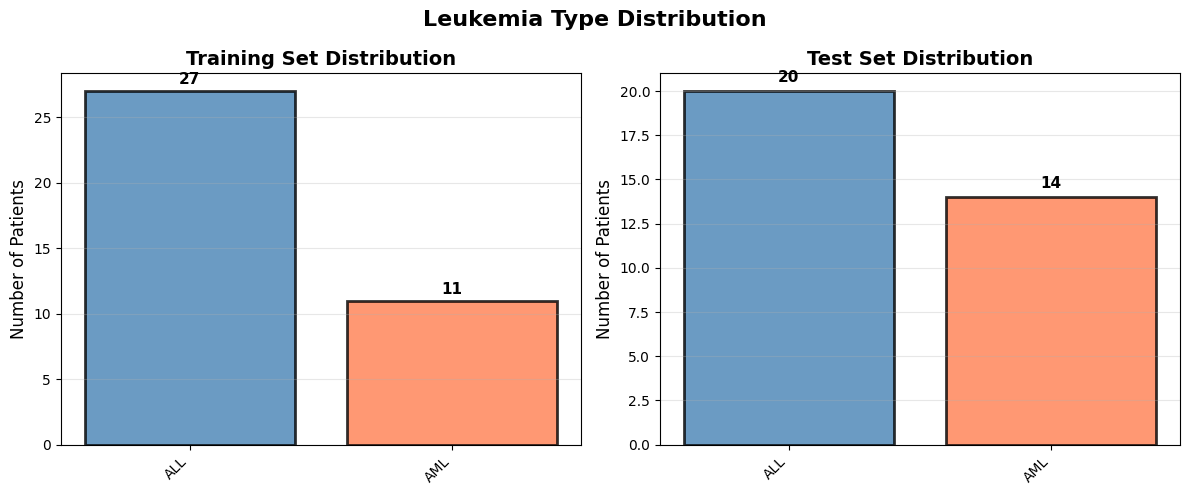

   ✓ Distribution looks relatively balanced - good for modeling!

[5] Feature selection using Random Forest...
   Training Random Forest on all genes...
   ✓ Reduced from 7129 genes to 100 most important genes

   Top 10 most important genes:
      1. 1833: 0.019747
      2. 1925: 0.015596
      3. 1881: 0.014563
      4. 759: 0.012343
      5. 2287: 0.012018
      6. 5898: 0.011667
      7. 3251: 0.011293
      8. 2019: 0.010357
      9. 6361: 0.010093
      10. 3257: 0.009975


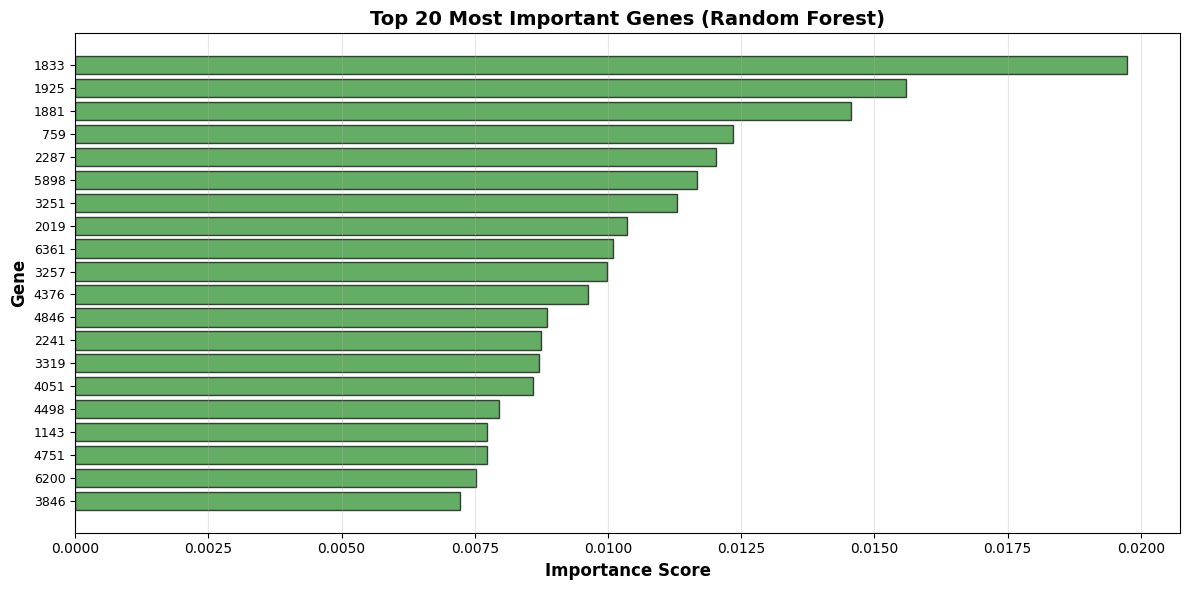


   ✓ Feature selection complete using Random Forest importance scores

[6] Scaling features (standardization)...
   ✓ All genes standardized to mean=0, std=1
   Training data shape: (38, 100)
   Test data shape: (34, 100)

[7] Preparing final data and cross-validation strategy...
   ✓ Using StratifiedKFold with 5 splits
   ✓ Training data ready: (38, 100)
   ✓ Test data ready: (34, 100)

[8] Hyperparameter tuning with GridSearchCV...

   Testing all parameter combinations...
Fitting 5 folds for each of 28 candidates, totalling 140 fits

   ✓ Grid search complete!
   Best parameters found:
      C (regularization): 0.001
      Penalty: l2
      Solver: liblinear

   ✓ Best CV Accuracy: 1.0000 (100.00%)

[9] Making predictions on test set...
   ✓ Predictions complete
   Training samples predicted: 38
   Test samples predicted: 34

[10] Calculating evaluation metrics...

MODEL PERFORMANCE SUMMARY

 Training Set:
   Accuracy: 1.0000 (100.00%)

Test Set (Independent Validation):
   Accurac

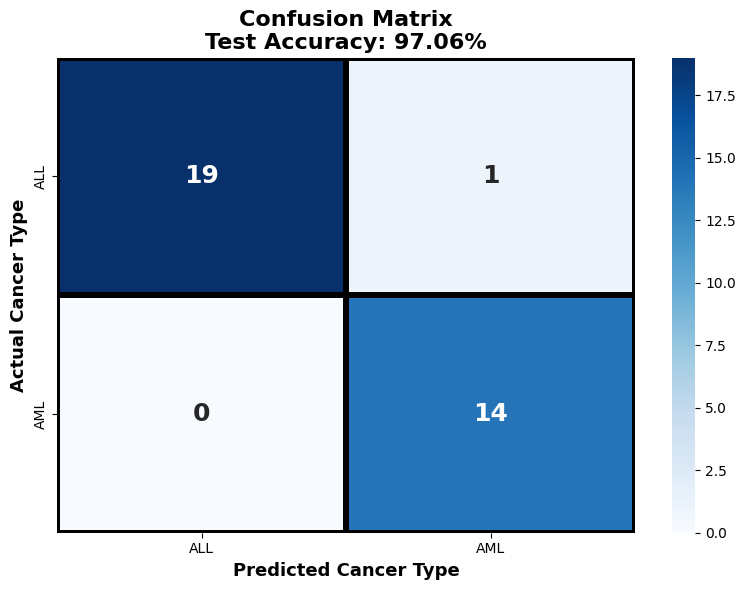


Confusion Matrix Breakdown:
  True Negatives (TN):  Correctly identified ALL
  False Positives (FP): ALL wrongly classified as AML
  False Negatives (FN): AML wrongly classified as ALL ← Critical errors!
  True Positives (TP):  Correctly identified AML

Per-Class Accuracy:
  ALL: 19/20 correct (95.0%)
  AML: 14/14 correct (100.0%)

[13] Creating ROC curve...


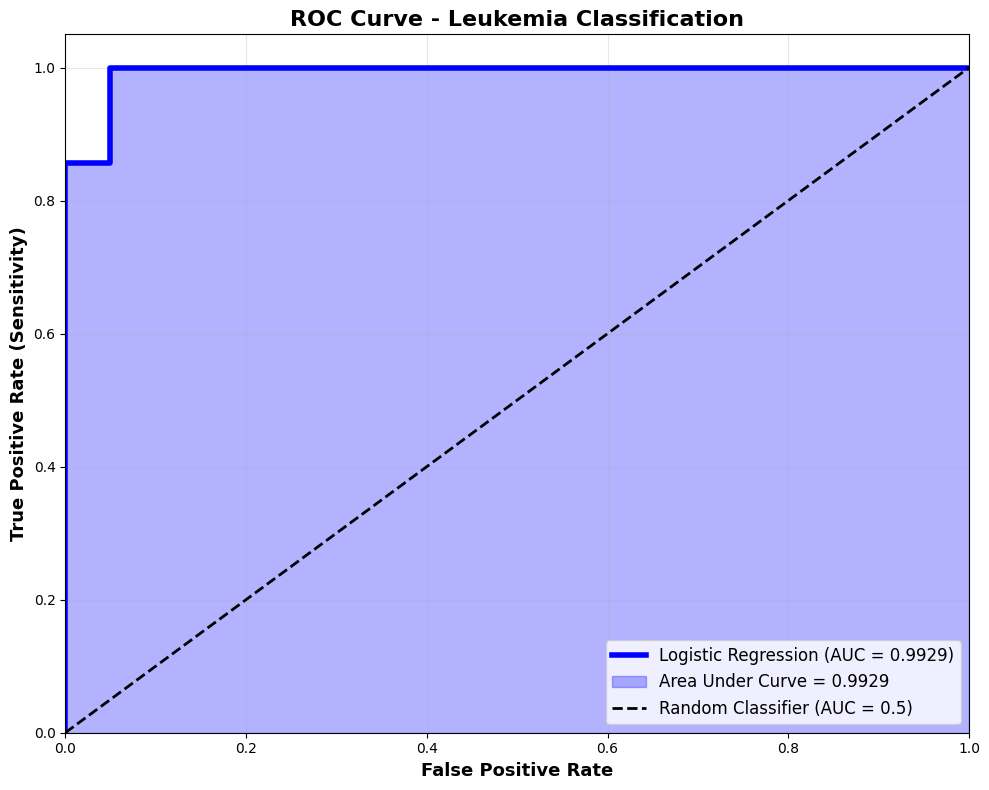


   ROC AUC Interpretation:
   EXCELLENT (AUC ≥ 0.95) - Model nearly perfect!


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, 
    f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("LEUKEMIA CLASSIFICATION - ALL vs AML")
print("Dataset: Golub et al. (1999) Gene Expression")
print("Goal: Classify Acute Lymphoblastic Leukemia (ALL) vs Acute Myeloid Leukemia (AML)")
print("="*80)

# Step 1: Loading training, test, and label data

print("\n[1] Loading data...")

data_train = pd.read_csv('data_set_ALL_AML_train.csv')
data_test = pd.read_csv('data_set_ALL_AML_independent.csv')
labels = pd.read_csv('actual.csv')

print(f"   Training data shape: {data_train.shape}")
print(f"   Test data shape: {data_test.shape}")
print(f"   Labels shape: {labels.shape}")

# Step 2: Preprocess gene expression data (for removing metadata, transpose)

print("\n[2] Preprocessing data...")

def preprocess_gene_data(df):
    cols_to_drop = [col for col in df.columns if 'call' in col.lower()]
    cols_to_drop += ['Gene Description', 'Gene Accession Number']
    cols_to_drop = [col for col in cols_to_drop if col in df.columns]
    
    df_processed = df.drop(columns=cols_to_drop, errors='ignore')
    df_processed = df_processed.T
    df_processed.index = df_processed.index.astype(str)
    
    return df_processed

X_train = preprocess_gene_data(data_train)
X_test = preprocess_gene_data(data_test)

print(f"   ✓ Training samples: {len(X_train)}")
print(f"   ✓ Test samples: {len(X_test)}")
print(f"   ✓ Genes (features): {X_train.shape[1]}")

# Step 3: Matching patient labels with samples

print("\n[3] Matching labels to samples...")

labels['patient'] = labels['patient'].astype(str)
labels_dict = dict(zip(labels['patient'], labels['cancer']))

y_train = X_train.index.map(labels_dict)
y_test = X_test.index.map(labels_dict)

train_mask = y_train.notna()
test_mask = y_test.notna()

X_train = X_train[train_mask]
y_train = y_train[train_mask]
X_test = X_test[test_mask]
y_test = y_test[test_mask]

classes = sorted(y_train.unique())

print(f"   Cancer types to classify: {classes}")
print(f"   Final training samples: {len(X_train)}")
print(f"   Final test samples: {len(X_test)}")

print(f"\n   Training distribution:")
for cls in classes:
    count = sum(y_train == cls)
    print(f"      {cls}: {count} patients ({count/len(y_train)*100:.1f}%)")

print(f"\n   Test distribution:")
for cls in classes:
    count = sum(y_test == cls)
    print(f"      {cls}: {count} patients ({count/len(y_test)*100:.1f}%)")

# Step 4: Visualize class distribution
print("\n[4] Visualizing class distribution...")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, data, title in zip(axes, [y_train, y_test], ['Training', 'Test']):
    counts = data.value_counts().sort_index()
    
    ax.bar(range(len(counts)), counts.values, 
           color=['steelblue', 'coral'], 
           alpha=0.8, edgecolor='black', linewidth=2)
    
    ax.set_xticks(range(len(counts)))
    ax.set_xticklabels(counts.index, rotation=45, ha='right')
    ax.set_title(f'{title} Set Distribution', fontsize=14, fontweight='bold')
    ax.set_ylabel('Number of Patients', fontsize=12)
    ax.grid(axis='y', alpha=0.3)
    
    for i, v in enumerate(counts.values):
        ax.text(i, v + 0.5, str(v), ha='center', fontweight='bold', fontsize=11)

plt.suptitle('Leukemia Type Distribution', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("   ✓ Distribution looks relatively balanced - good for modeling!")

# Step 5: Feature selection using Random Forest importance

print("\n[5] Feature selection using Random Forest...")

rf_selector = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

print("   Training Random Forest on all genes...")
rf_selector.fit(X_train, y_train)

importances = rf_selector.feature_importances_
n_features = 100

top_genes_idx = np.argsort(importances)[-n_features:][::-1]

X_train_selected = X_train.iloc[:, top_genes_idx]
X_test_selected = X_test.iloc[:, top_genes_idx]

print(f"   ✓ Reduced from {X_train.shape[1]} genes to {n_features} most important genes")

selected_genes = X_train.columns[top_genes_idx]

print(f"\n   Top 10 most important genes:")
for i, (gene, importance) in enumerate(zip(selected_genes[:10], importances[top_genes_idx][:10]), 1):
    print(f"      {i}. {gene}: {importance:.6f}")

plt.figure(figsize=(12, 6))
top_20_genes = selected_genes[:20]
top_20_importance = importances[top_genes_idx][:20]

plt.barh(range(20), top_20_importance, color='forestgreen', alpha=0.7, edgecolor='black')
plt.yticks(range(20), top_20_genes, fontsize=9)
plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
plt.ylabel('Gene', fontsize=12, fontweight='bold')
plt.title('Top 20 Most Important Genes (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n   ✓ Feature selection complete using Random Forest importance scores")

# Step 6: Standardize features (mean=0, std=1)

print("\n[6] Scaling features (standardization)...")

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

print("   ✓ All genes standardized to mean=0, std=1")
print(f"   Training data shape: {X_train_scaled.shape}")
print(f"   Test data shape: {X_test_scaled.shape}")

# Step 7: Prepare final datasets and cross-validation strategy
print("\n[7] Preparing final data and cross-validation strategy...")

X_train_final = X_train_scaled
X_test_final = X_test_scaled
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(f"   ✓ Using StratifiedKFold with {cv.n_splits} splits")
print(f"   ✓ Training data ready: {X_train_final.shape}")
print(f"   ✓ Test data ready: {X_test_final.shape}")

# Step 8: Hyperparameter tuning with GridSearchCV

print("\n[8] Hyperparameter tuning with GridSearchCV...")

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [5000]
}

grid_search = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("\n   Testing all parameter combinations...")
grid_search.fit(X_train_final, y_train)

best_model = grid_search.best_estimator_

print(f"\n   ✓ Grid search complete!")
print(f"   Best parameters found:")
print(f"      C (regularization): {grid_search.best_params_['C']}")
print(f"      Penalty: {grid_search.best_params_['penalty']}")
print(f"      Solver: {grid_search.best_params_['solver']}")
print(f"\n   ✓ Best CV Accuracy: {grid_search.best_score_:.4f} ({grid_search.best_score_*100:.2f}%)")

# Step 9: Make predictions on test set

print("\n[9] Making predictions on test set...")

y_train_pred = best_model.predict(X_train_final)
y_test_pred = best_model.predict(X_test_final)
y_test_proba = best_model.predict_proba(X_test_final)

print("   ✓ Predictions complete")
print(f"   Training samples predicted: {len(y_train_pred)}")
print(f"   Test samples predicted: {len(y_test_pred)}")

# Step 10: Calculate evaluation metrics

print("\n[10] Calculating evaluation metrics...")

train_acc = accuracy_score(y_train, y_train_pred)

test_acc = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, pos_label=classes[1])
test_recall = recall_score(y_test, y_test_pred, pos_label=classes[1])
test_f1 = f1_score(y_test, y_test_pred, pos_label=classes[1])

if len(classes) == 2:
    y_test_proba_positive = y_test_proba[:, 1]
    test_roc_auc = roc_auc_score(y_test == classes[1], y_test_proba_positive)
else:
    test_roc_auc = 0

print("\n" + "="*80)
print("MODEL PERFORMANCE SUMMARY")
print("="*80)

print(f"\n Training Set:")
print(f"   Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")

print(f"\nTest Set (Independent Validation):")
print(f"   Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"   Precision: {test_precision:.4f} (How many predicted AML are actually AML)")
print(f"   Recall:    {test_recall:.4f} (How many actual AML are correctly identified)")
print(f"   F1-Score:  {test_f1:.4f} (Harmonic mean of precision and recall)")
print(f"   ROC AUC:   {test_roc_auc:.4f} (Area under ROC curve)")

if train_acc - test_acc > 0.1:
    print("\n    Warning: Possible overfitting (training accuracy >> test accuracy)")
else:
    print("\n   ✓ Good generalization (training and test accuracy similar)")

print("\n" + "="*80)

# Step 11: Display detailed classification report

print("\n[11] Detailed classification report...")

print("\nClassification Report (Test Set):")
print("="*60)
print(classification_report(y_test, y_test_pred, target_names=classes))

print("\nMetric Definitions:")
print("  Precision: Of all patients predicted as AML, how many actually have AML?")
print("  Recall: Of all patients with AML, how many did we correctly identify?")
print("  F1-Score: Balance between precision and recall")
print("  Support: Number of patients with this cancer type in test set")

# Step 12: Create and visualize confusion matrix

print("\n[12] Creating confusion matrix...")

cm = confusion_matrix(y_test, y_test_pred, labels=classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes,
            annot_kws={'size': 18, 'fontweight': 'bold'},
            linewidths=3, linecolor='black')

plt.title(f'Confusion Matrix\nTest Accuracy: {test_acc*100:.2f}%', 
          fontsize=16, fontweight='bold')
plt.xlabel('Predicted Cancer Type', fontsize=13, fontweight='bold')
plt.ylabel('Actual Cancer Type', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nConfusion Matrix Breakdown:")
print(f"  True Negatives (TN):  Correctly identified {classes[0]}")
print(f"  False Positives (FP): {classes[0]} wrongly classified as {classes[1]}")
print(f"  False Negatives (FN): {classes[1]} wrongly classified as {classes[0]} ← Critical errors!")
print(f"  True Positives (TP):  Correctly identified {classes[1]}")

print("\nPer-Class Accuracy:")
for i, cls in enumerate(classes):
    class_mask = y_test == cls
    class_correct = sum((y_test_pred == cls) & class_mask)
    class_total = sum(class_mask)
    print(f"  {cls}: {class_correct}/{class_total} correct ({class_correct/class_total*100:.1f}%)")

# Step 13: Plot ROC curve

if len(classes) == 2:
    print("\n[13] Creating ROC curve...")
    
    fpr, tpr, thresholds = roc_curve(y_test == classes[1], y_test_proba_positive)
    
    plt.figure(figsize=(10, 8))
    
    plt.plot(fpr, tpr, color='blue', lw=4, 
             label=f'Logistic Regression (AUC = {test_roc_auc:.4f})')
    
    plt.fill_between(fpr, tpr, alpha=0.3, color='blue', 
                     label=f'Area Under Curve = {test_roc_auc:.4f}')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, 
             label='Random Classifier (AUC = 0.5)')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
    plt.ylabel('True Positive Rate (Sensitivity)', fontsize=13, fontweight='bold')
    plt.title('ROC Curve - Leukemia Classification', fontsize=16, fontweight='bold')
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\n   ROC AUC Interpretation:")
    if test_roc_auc >= 0.95:
        print(f"   EXCELLENT (AUC ≥ 0.95) - Model nearly perfect!")
    elif test_roc_auc >= 0.90:
        print(f"   EXCELLENT (AUC ≥ 0.90)")
    elif test_roc_auc >= 0.80:
        print(f"   ✓ GOOD (AUC ≥ 0.80)")
    else:
        print(f"   FAIR (AUC < 0.80)")
else:
    print("\n[13] ROC curve skipped (multi-class problem)")
